# SPY/SPXL Trading Strategy

This notebook implements a leveraged ETF rotation strategy between SPY and SPXL based on moving averages:
- **SPXL** (3x leveraged S&P 500): Used during strong uptrends
- **SPY** (S&P 500): Used during corrections within uptrends
- **Cash**: Held during downtrends

# SPY/SPXL Trading Strategy

This notebook implements a leveraged ETF rotation strategy between SPY and SPXL based on moving averages:
- **SPXL** (3x leveraged S&P 500): Used during strong uptrends
- **SPY** (S&P 500): Used during corrections within uptrends
- **Cash**: Held during downtrends

## 1. Import Required Libraries

Import essential libraries for data analysis, visualization, and trading strategy development.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Market Data

Load historical price data for SPY and SPXL using yfinance.

In [3]:
# Download SPY and SPXL data
start_date = '2020-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

print("Downloading SPY and SPXL data...")
spy = yf.download('SPY', start=start_date, end=end_date, progress=False, auto_adjust=True)
spxl = yf.download('SPXL', start=start_date, end=end_date, progress=False, auto_adjust=True)

# Check if data was downloaded successfully
if spy.empty or spxl.empty:
    raise ValueError("Failed to download data. Please check your internet connection and try again.")

# Extract Close prices (handle MultiIndex columns from yfinance)
if isinstance(spy.columns, pd.MultiIndex):
    spy_close = spy[('Close', 'SPY')]
    spxl_close = spxl[('Close', 'SPXL')]
else:
    spy_close = spy['Close']
    spxl_close = spxl['Close']

# Create combined dataframe
df = pd.DataFrame({
    'SPY_Close': spy_close,
    'SPXL_Close': spxl_close,
})

# Calculate returns
df['SPY_Returns'] = df['SPY_Close'].pct_change()
df['SPXL_Returns'] = df['SPXL_Close'].pct_change()

# Drop NaN values
df.dropna(inplace=True)

print(f"Loaded {len(df)} days of data from {df.index[0].date()} to {df.index[-1].date()}")
print(f"\nSPY: ${df['SPY_Close'].iloc[0]:.2f} → ${df['SPY_Close'].iloc[-1]:.2f}")
print(f"SPXL: ${df['SPXL_Close'].iloc[0]:.2f} → ${df['SPXL_Close'].iloc[-1]:.2f}")
df.head()

Loaded 1490 days of data from 2020-01-03 to 2025-12-05

SPY: $296.32 → $685.69
SPXL: $63.93 → $224.53
Loaded 1490 days of data from 2020-01-03 to 2025-12-05

SPY: $296.32 → $685.69
SPXL: $63.93 → $224.53


,SPY_Close,SPXL_Close,SPY_Returns,SPXL_Returns
Date,,,,
2020-01-03,296.317719,63.929569,-0.007572,-0.024003
2020-01-06,297.448242,64.672272,0.003815,0.011618
2020-01-07,296.611877,64.180367,-0.002812,-0.007606
2020-01-08,298.192688,65.164192,0.005330,0.015329
2020-01-09,300.214600,66.485619,0.006781,0.020278


## 3. Calculate Moving Averages

Calculate the 30-day and 120-day moving averages for SPY.

In [4]:
# Calculate moving averages for SPY
df['SPY_SMA_30'] = df['SPY_Close'].rolling(window=30).mean()
df['SPY_SMA_120'] = df['SPY_Close'].rolling(window=120).mean()

# Drop NaN values from rolling calculations
df.dropna(inplace=True)

print("Moving averages calculated")
print(f"\nCurrent SPY Price: ${df['SPY_Close'].iloc[-1]:.2f}")
print(f"Current 30-day MA: ${df['SPY_SMA_30'].iloc[-1]:.2f}")
print(f"Current 120-day MA: ${df['SPY_SMA_120'].iloc[-1]:.2f}")
df[['SPY_Close', 'SPY_SMA_30', 'SPY_SMA_120', 'SPXL_Close']].tail(10)

Moving averages calculated

Current SPY Price: $685.69
Current 30-day MA: $676.35
Current 120-day MA: $649.91


,SPY_Close,SPY_SMA_30,SPY_SMA_120,SPXL_Close
Date,,,,
2025-11-21,659.030029,672.187333,643.598636,200.429993
2025-11-24,668.729980,672.377000,644.233630,209.179993
2025-11-25,675.020020,672.803335,644.944905,214.970001
2025-11-26,679.679993,673.287002,645.644551,219.240005
2025-11-28,683.390015,674.045335,646.370640,222.729996
2025-12-01,680.270020,674.574668,647.042558,219.630005
2025-12-02,681.530029,674.915670,647.739227,220.720001
2025-12-03,683.890015,675.335671,648.435759,222.979996
2025-12-04,684.390015,675.888672,649.192388,223.550003


## 4. Visualize SPY Price and Moving Averages

Plot SPY price with the 30-day and 120-day moving averages.

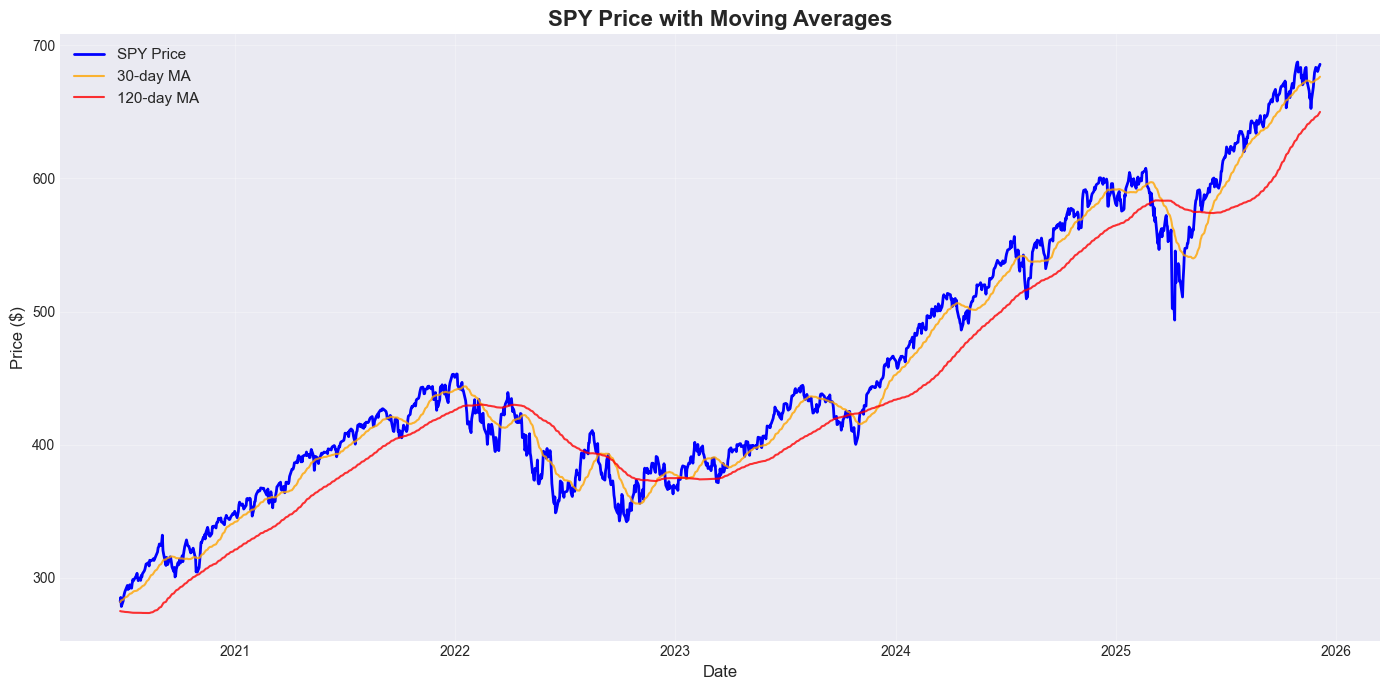

In [5]:
fig, ax = plt.subplots(figsize=(14, 7))

# Plot SPY price and moving averages
ax.plot(df.index, df['SPY_Close'], label='SPY Price', linewidth=2, color='blue')
ax.plot(df.index, df['SPY_SMA_30'], label='30-day MA', linewidth=1.5, color='orange', alpha=0.8)
ax.plot(df.index, df['SPY_SMA_120'], label='120-day MA', linewidth=1.5, color='red', alpha=0.8)

# Add legend and labels
ax.set_title('SPY Price with Moving Averages', fontsize=16, fontweight='bold')
ax.set_ylabel('Price ($)', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Implement SPY/SPXL Rotation Strategy

**Strategy Rules:**
- Hold **SPXL** when 30-day MA is above 120-day MA AND price is above 30-day MA (strong uptrend)
- Hold **SPY** when 30-day MA is above 120-day MA BUT price drops below 30-day MA (uptrend with correction)
- Hold **Cash** when 30-day MA is below 120-day MA (downtrend - stay out of market)
- This aims to use leverage during strong uptrends while protecting capital during downtrends

In [6]:
# Initialize position: 0 = SPY, 1 = SPXL, -1 = Cash
df['Position'] = -1  # Start with Cash

# Determine position based on rules
for i in range(len(df)):
    current_price = df['SPY_Close'].iloc[i]
    sma_30 = df['SPY_SMA_30'].iloc[i]
    sma_120 = df['SPY_SMA_120'].iloc[i]
    
    if sma_30 > sma_120:
        # 30-day MA above 120-day MA (uptrend)
        if current_price >= sma_30:
            # Price above 30-day MA: Buy SPXL
            df.iloc[i, df.columns.get_loc('Position')] = 1
        else:
            # Price below 30-day MA: Hold SPY (defensive)
            df.iloc[i, df.columns.get_loc('Position')] = 0
    else:
        # 30-day MA below 120-day MA (downtrend): Hold Cash
        df.iloc[i, df.columns.get_loc('Position')] = -1

# Create labels for positions
df['Holding'] = df['Position'].map({0: 'SPY', 1: 'SPXL', -1: 'Cash'})

# Detect position changes (switches)
df['Switch'] = df['Position'].diff().fillna(0)
switches = df[df['Switch'] != 0]

# Calculate strategy returns based on position
df['Strategy_Returns'] = np.where(
    df['Position'] == 1,
    df['SPXL_Returns'],  # Hold SPXL
    np.where(
        df['Position'] == 0,
        df['SPY_Returns'],  # Hold SPY
        0  # Hold Cash (0% return)
    )
)

print(f"Total position switches: {len(switches)}")
print(f"\nPosition distribution:")
print(df['Holding'].value_counts())
print(f"\nRecent switches:")
print(switches[['SPY_Close', 'SPY_SMA_30', 'SPY_SMA_120', 'Holding']].tail(10))

Total position switches: 115

Position distribution:
Holding
SPXL    816
SPY     281
Cash    274
Name: count, dtype: int64

Recent switches:
             SPY_Close  SPY_SMA_30  SPY_SMA_120 Holding
Date                                                   
2025-08-01  620.001038  620.996000   581.796079     SPY
2025-08-04  629.424927  622.222266   582.044653    SPXL
2025-10-10  653.020020  658.613536   617.899835     SPY
2025-10-13  663.039978  659.272648   619.056481    SPXL
2025-10-16  660.640015  661.281136   622.094843     SPY
2025-10-17  664.390015  661.912453   623.067195    SPXL
2025-11-06  670.309998  671.316665   635.933784     SPY
2025-11-10  681.440002  672.213664   637.362825    SPXL
2025-11-13  672.039978  673.365997   639.890442     SPY
2025-11-25  675.020020  672.803335   644.944905    SPXL


## 6. Backtest Strategy Performance

Compare the rotation strategy against buy-and-hold SPY and SPXL.

In [7]:
# Calculate cumulative returns
df['Cumulative_SPY'] = (1 + df['SPY_Returns']).cumprod()
df['Cumulative_SPXL'] = (1 + df['SPXL_Returns']).cumprod()
df['Cumulative_Strategy'] = (1 + df['Strategy_Returns']).cumprod()

# Performance metrics function
def calculate_metrics(returns_series, name):
    cumulative_return = (returns_series.iloc[-1] - 1) * 100
    
    # Annualized return
    days = len(returns_series)
    years = days / 252
    annual_return = ((returns_series.iloc[-1]) ** (1/years) - 1) * 100
    
    # Volatility (annualized)
    daily_returns = returns_series.pct_change().dropna()
    volatility = daily_returns.std() * np.sqrt(252) * 100
    
    # Sharpe ratio (assuming 0% risk-free rate)
    sharpe_ratio = (annual_return / volatility) if volatility != 0 else 0
    
    # Maximum drawdown
    running_max = returns_series.expanding().max()
    drawdown = (returns_series - running_max) / running_max
    max_drawdown = drawdown.min() * 100
    
    return {
        'Total Return': f"{cumulative_return:.2f}%",
        'Annual Return': f"{annual_return:.2f}%",
        'Volatility': f"{volatility:.2f}%",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Max Drawdown': f"{max_drawdown:.2f}%"
    }

# Calculate metrics for all strategies
print("=" * 70)
print("ROTATION STRATEGY (SPY/SPXL)")
print("=" * 70)
strategy_metrics = calculate_metrics(df['Cumulative_Strategy'], 'Strategy')
for key, value in strategy_metrics.items():
    print(f"{key:20s}: {value}")

print("\n" + "=" * 70)
print("BUY & HOLD SPY")
print("=" * 70)
spy_metrics = calculate_metrics(df['Cumulative_SPY'], 'SPY')
for key, value in spy_metrics.items():
    print(f"{key:20s}: {value}")

print("\n" + "=" * 70)
print("BUY & HOLD SPXL")
print("=" * 70)
spxl_metrics = calculate_metrics(df['Cumulative_SPXL'], 'SPXL')
for key, value in spxl_metrics.items():
    print(f"{key:20s}: {value}")

ROTATION STRATEGY (SPY/SPXL)
Total Return        : 3906.58%
Annual Return       : 97.06%
Volatility          : 27.48%
Sharpe Ratio        : 3.53
Max Drawdown        : -23.88%

BUY & HOLD SPY
Total Return        : 136.65%
Annual Return       : 17.16%
Volatility          : 17.15%
Sharpe Ratio        : 1.00
Max Drawdown        : -24.50%

BUY & HOLD SPXL
Total Return        : 434.93%
Annual Return       : 36.10%
Volatility          : 50.57%
Sharpe Ratio        : 0.71
Max Drawdown        : -63.80%


## 7. Visualize Strategy Performance

Compare the rotation strategy against buy-and-hold approaches and show position switches.

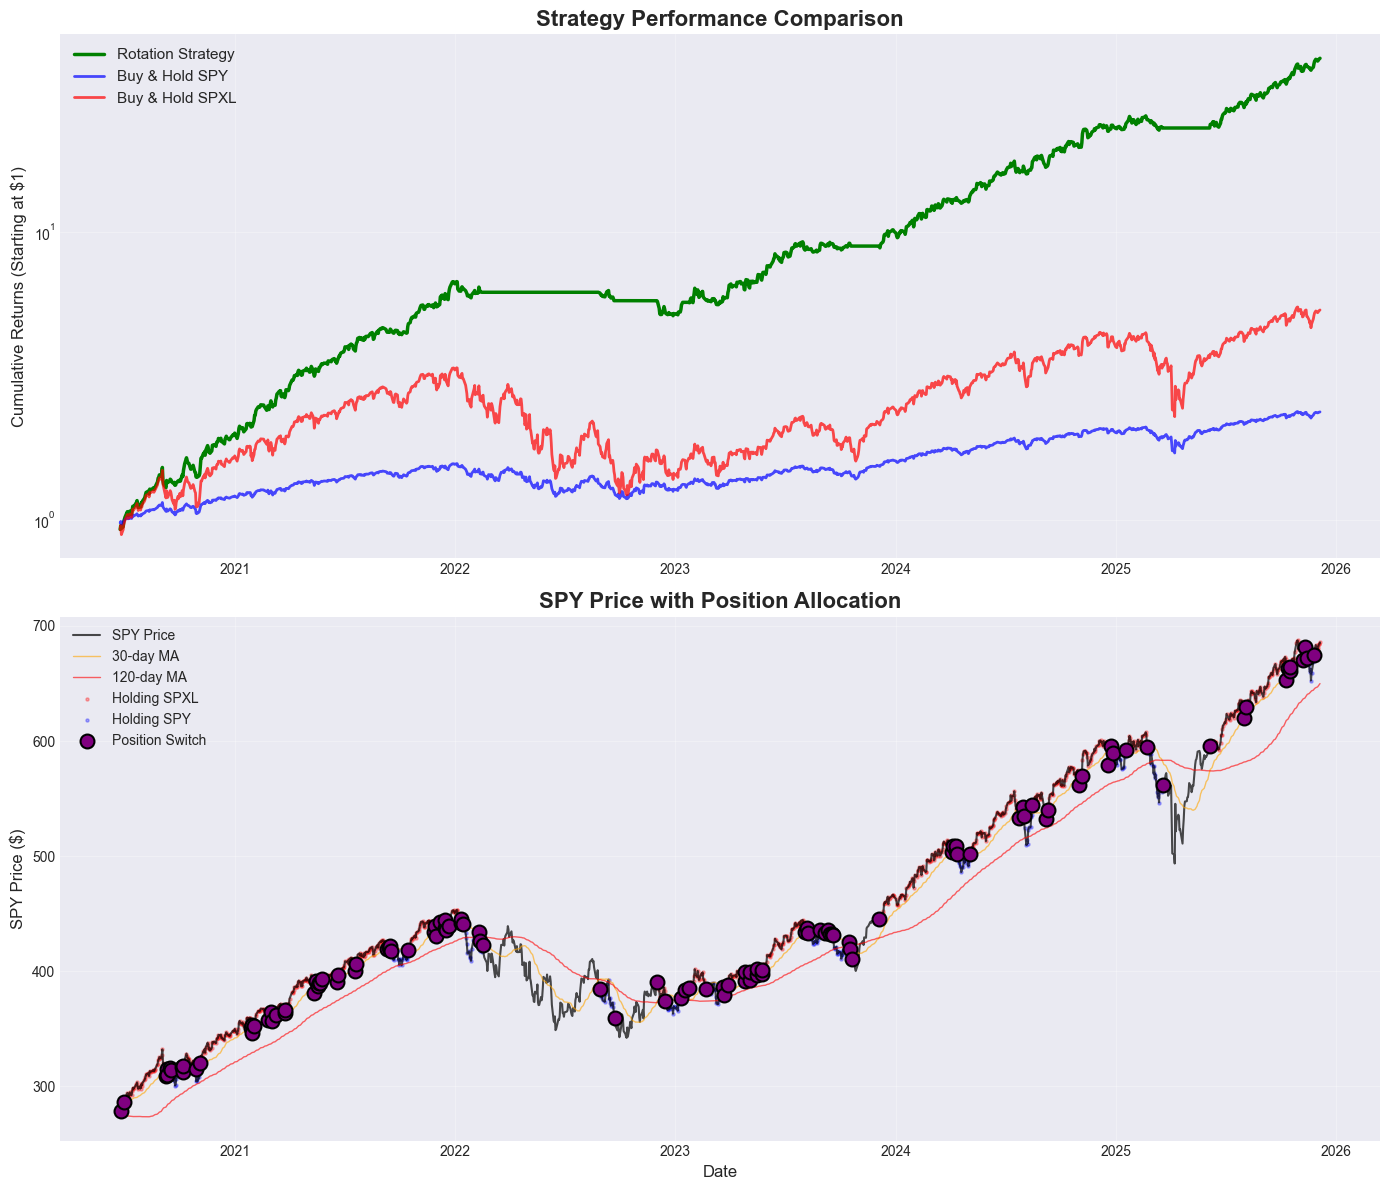


Final Portfolio Values (Starting with $10,000):
Rotation Strategy: $400,658.40
Buy & Hold SPY:    $23,664.71
Buy & Hold SPXL:   $53,493.35


In [8]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plot 1: Cumulative returns comparison
axes[0].plot(df.index, df['Cumulative_Strategy'], 
             label='Rotation Strategy', linewidth=2.5, color='green')
axes[0].plot(df.index, df['Cumulative_SPY'], 
             label='Buy & Hold SPY', linewidth=2, color='blue', alpha=0.7)
axes[0].plot(df.index, df['Cumulative_SPXL'], 
             label='Buy & Hold SPXL', linewidth=2, color='red', alpha=0.7)
axes[0].set_title('Strategy Performance Comparison', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Cumulative Returns (Starting at $1)', fontsize=12)
axes[0].legend(loc='best', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')  # Log scale to see all strategies clearly

# Plot 2: SPY price with position indicators
axes[1].plot(df.index, df['SPY_Close'], label='SPY Price', linewidth=1.5, color='black', alpha=0.7)
axes[1].plot(df.index, df['SPY_SMA_30'], label='30-day MA', linewidth=1, color='orange', alpha=0.6)
axes[1].plot(df.index, df['SPY_SMA_120'], label='120-day MA', linewidth=1, color='red', alpha=0.6)

# Highlight periods when holding SPXL
spxl_periods = df[df['Position'] == 1]
if len(spxl_periods) > 0:
    axes[1].scatter(spxl_periods.index, spxl_periods['SPY_Close'], 
                    color='red', s=5, alpha=0.3, label='Holding SPXL')

# Highlight periods when holding SPY
spy_periods = df[df['Position'] == 0]
if len(spy_periods) > 0:
    axes[1].scatter(spy_periods.index, spy_periods['SPY_Close'], 
                    color='blue', s=5, alpha=0.3, label='Holding SPY')

# Mark position switches
switches = df[df['Switch'] != 0]
axes[1].scatter(switches.index, switches['SPY_Close'], 
                marker='o', color='purple', s=100, label='Position Switch', zorder=5, edgecolors='black', linewidths=1.5)

axes[1].set_title('SPY Price with Position Allocation', fontsize=16, fontweight='bold')
axes[1].set_ylabel('SPY Price ($)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final portfolio values
initial_investment = 10000
print(f"\nFinal Portfolio Values (Starting with ${initial_investment:,}):")
print(f"Rotation Strategy: ${initial_investment * df['Cumulative_Strategy'].iloc[-1]:,.2f}")
print(f"Buy & Hold SPY:    ${initial_investment * df['Cumulative_SPY'].iloc[-1]:,.2f}")
print(f"Buy & Hold SPXL:   ${initial_investment * df['Cumulative_SPXL'].iloc[-1]:,.2f}")

## 8. Strategy Analysis & Next Steps

### Current Position Status

In [ ]:
# Current position and status
current_price = df['SPY_Close'].iloc[-1]
current_ma30 = df['SPY_SMA_30'].iloc[-1]
current_ma120 = df['SPY_SMA_120'].iloc[-1]
current_holding = df['Holding'].iloc[-1]

print("=" * 60)
print("CURRENT POSITION STATUS")
print("=" * 60)
print(f"Current Date:     {df.index[-1].date()}")
print(f"SPY Price:        ${current_price:.2f}")
print(f"30-day MA:        ${current_ma30:.2f} ({((current_price/current_ma30-1)*100):+.2f}%)")
print(f"120-day MA:       ${current_ma120:.2f} ({((current_price/current_ma120-1)*100):+.2f}%)")
print(f"\nCurrent Holding:  {current_holding}")
print("=" * 60)

# Calculate time in each position
position_counts = df['Holding'].value_counts()
total_days = len(df)
print(f"\nTime in each position:")
for pos, count in position_counts.items():
    print(f"  {pos}: {count} days ({count/total_days*100:.1f}%)")

# Show recent position history
print(f"\nRecent position changes:")
recent_switches = df[df['Switch'] != 0].tail(5)
for idx, row in recent_switches.iterrows():
    print(f"  {idx.date()}: Switched to {row['Holding']} at ${row['SPY_Close']:.2f}")

### Ideas for Further Enhancement:
- **Transaction Costs**: Add brokerage fees and slippage to simulate real trading
- **Different MA Periods**: Optimize the 30 and 120-day periods for better performance
- **Additional Filters**: Add volume, RSI, or volatility filters to improve timing
- **Risk Management**: Implement stop-loss or position sizing rules
- **Tax Considerations**: Account for short-term vs long-term capital gains
- **Alternative Leveraged ETFs**: Test with other 2x or 3x leveraged instruments
- **Market Regime Detection**: Use volatility measures to adjust strategy parameters
- **Walk-Forward Analysis**: Test strategy robustness across different time periods